Mesh Denoising
==============

*Important:* Please read the [installation page](http://gpeyre.github.io/numerical-tours/installation_python/) for details about how to install the toolboxes.
$\newcommand{\dotp}[2]{\langle #1, #2 \rangle}$
$\newcommand{\enscond}[2]{\lbrace #1, #2 \rbrace}$
$\newcommand{\pd}[2]{ \frac{ \partial #1}{\partial #2} }$
$\newcommand{\umin}[1]{\underset{#1}{\min}\;}$
$\newcommand{\umax}[1]{\underset{#1}{\max}\;}$
$\newcommand{\umin}[1]{\underset{#1}{\min}\;}$
$\newcommand{\uargmin}[1]{\underset{#1}{argmin}\;}$
$\newcommand{\norm}[1]{\|#1\|}$
$\newcommand{\abs}[1]{\left|#1\right|}$
$\newcommand{\choice}[1]{ \left\{  \begin{array}{l} #1 \end{array} \right. }$
$\newcommand{\pa}[1]{\left(#1\right)}$
$\newcommand{\diag}[1]{{diag}\left( #1 \right)}$
$\newcommand{\qandq}{\quad\text{and}\quad}$
$\newcommand{\qwhereq}{\quad\text{where}\quad}$
$\newcommand{\qifq}{ \quad \text{if} \quad }$
$\newcommand{\qarrq}{ \quad \Longrightarrow \quad }$
$\newcommand{\ZZ}{\mathbb{Z}}$
$\newcommand{\CC}{\mathbb{C}}$
$\newcommand{\RR}{\mathbb{R}}$
$\newcommand{\EE}{\mathbb{E}}$
$\newcommand{\Zz}{\mathcal{Z}}$
$\newcommand{\Ww}{\mathcal{W}}$
$\newcommand{\Vv}{\mathcal{V}}$
$\newcommand{\Nn}{\mathcal{N}}$
$\newcommand{\NN}{\mathcal{N}}$
$\newcommand{\Hh}{\mathcal{H}}$
$\newcommand{\Bb}{\mathcal{B}}$
$\newcommand{\Ee}{\mathcal{E}}$
$\newcommand{\Cc}{\mathcal{C}}$
$\newcommand{\Gg}{\mathcal{G}}$
$\newcommand{\Ss}{\mathcal{S}}$
$\newcommand{\Pp}{\mathcal{P}}$
$\newcommand{\Ff}{\mathcal{F}}$
$\newcommand{\Xx}{\mathcal{X}}$
$\newcommand{\Mm}{\mathcal{M}}$
$\newcommand{\Ii}{\mathcal{I}}$
$\newcommand{\Dd}{\mathcal{D}}$
$\newcommand{\Ll}{\mathcal{L}}$
$\newcommand{\Tt}{\mathcal{T}}$
$\newcommand{\si}{\sigma}$
$\newcommand{\al}{\alpha}$
$\newcommand{\la}{\lambda}$
$\newcommand{\ga}{\gamma}$
$\newcommand{\Ga}{\Gamma}$
$\newcommand{\La}{\Lambda}$
$\newcommand{\si}{\sigma}$
$\newcommand{\Si}{\Sigma}$
$\newcommand{\be}{\beta}$
$\newcommand{\de}{\delta}$
$\newcommand{\De}{\Delta}$
$\newcommand{\phi}{\varphi}$
$\newcommand{\th}{\theta}$
$\newcommand{\om}{\omega}$
$\newcommand{\Om}{\Omega}$

This tour explores denoising of 3-D meshes using linear filtering, heat
diffusion and Sobolev regularization.

In [1]:
from __future__ import division

import numpy as np
import scipy as scp
import pylab as pyl
import matplotlib.pyplot as plt
import timeit
import time as tps


from nt_toolbox.general import *
from nt_toolbox.signal import *
from nt_toolbox.plot_mesh import *

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
%load_ext autoreload
%autoreload 2

3-D Triangulated Meshes
-----------------------
The topology of a triangulation is defined via a set of indexes $\Vv = \{1,\ldots,n\}$
that indexes the $n$ vertices, a set of edges $\Ee \subset \Vv \times \Vv$
and a set of $m$ faces $\Ff \subset \Vv  \times \Vv \times \Vv$.


We load a mesh. The set of faces $\Ff$ is stored in a matrix $F \in
\{1,\ldots,n\}^{3 \times m}$.
The positions $x_i \in \RR^3$, for $i \in V$, of the $n$ vertices
are stored in a matrix $X_0 = (x_{0,i})_{i=1}^n \in \RR^{3 \times n}$.

In [2]:
from nt_toolbox.read_mesh import *
X0,F = read_mesh("nt_toolbox/data/nefertiti.off")

Number $n$ of vertices and number $m$ of faces.

In [3]:
n = np.shape(X0)[1]
m = np.shape(F)[1]

Display the mesh in 3-D.

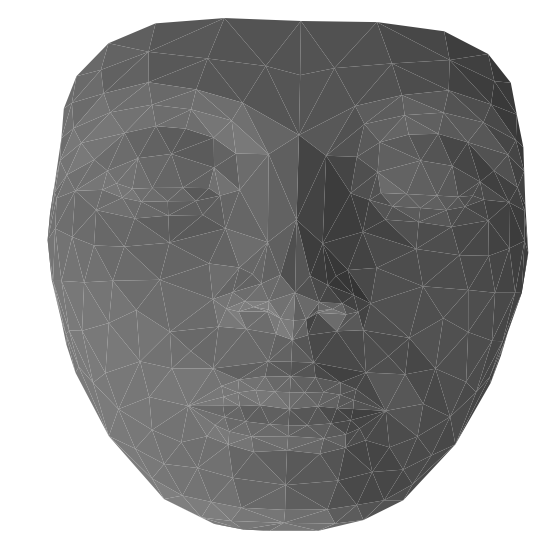

In [4]:
plt.figure(figsize=(10,10))
plot_mesh(X0, F)

Noisy Mesh
----------
We generate artificially a noisy mesh by random normal displacement along the normal.
We only perform normal displacements because tangencial displacements
do not impact the geometry of the mesh.


The parameter $\rho>0$ controls the amount of noise.

In [5]:
rho = 0.015

We compute the normals $N = (N_i)_{i=1}^n$ to the mesh.
This is obtained by averaging the normal to the faces ajacent to each
vertex.

In [6]:
from nt_toolbox.compute_normal import *
N = compute_normal(X0, F)

We create a noisy mesh by displacement of the vertices along the
normal direction
$$ x_i = x_{0,i} + \rho \epsilon_i N_i \in \RR^3 $$
where $\epsilon_i \sim \Nn(0,1)$ is a realization of a Gaussian random
variable,
and where $N_i \in \RR^3$ is the normal of the mesh for each vertex index
$i$.

In [7]:
from numpy import random
X = X0 + np.tile(rho*random.randn(n), (3,1))*N

Display the noisy mesh.

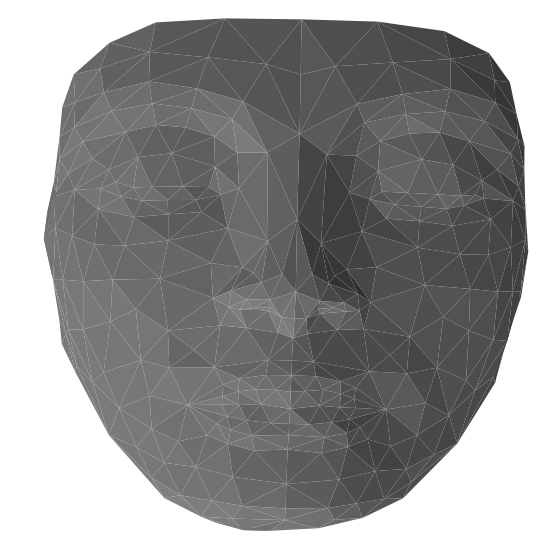

In [8]:
plt.figure(figsize=(10,10))
plot_mesh(X, F)

Adjacency Matrix
----------------
We define linear operators that compute local averages and differences on
the mesh.


First we compute the index of the edges that are in the mesh,
by extracting pairs of index in the $F$ matrix.

In [9]:
E = np.hstack((F[[0,1],:],F[[1,2],:],F[[2,0],:]))

Add the reversed edges. This defines the set of edges $\Ee$
that is stored in a matrix $E \in \{1,\ldots,n\}^{2 \times p}$.

In [10]:
from nt_toolbox.unique_columns import *
E = unique_columns(np.hstack((E,E[[1,0],:])))

We keep only oriented pairs of index $(i,j)$ such that $i<j$,
to avoid un-necessary computation.

In [11]:
E0 = E[:,E[0,:] < E[1,:]]

This defines a matrix
$E \in \{1,\ldots,n\}^{2 \times p_0}$ where $p_0=p/2$.

In [12]:
p0 = np.shape(E0)[1]

Display statistics of the mesh.

In [13]:
print("#vertices = %i, #faces = %i, #edges = %i" %(n,m,p0))

#vertices = 299, #faces = 562, #edges = 860


The weight matrix $W$ is the adjacency matrix
defined by
$$
      W_{i,j} = \choice{
          1 \qifq (i,j) \in \Ee, \\
          0 \quad \text{otherwise.}
      }
$$
Since most of the entries of $W$ are zero, we store it as a sparse
matrix.

In [14]:
from scipy import sparse

W = sparse.coo_matrix((np.ones(np.shape(E)[1]),(E[0,:],E[1,:])))

Compute the connectivity weight vector $ d \in \NN^n $
$$ d_i = \sum_{j} W_{i,j} $$
i.e. $d_i$ is the number of edges connected to $i$.

In [15]:
d = np.ravel((W.sum(0)))

Display the statistics of mesh connectivity.

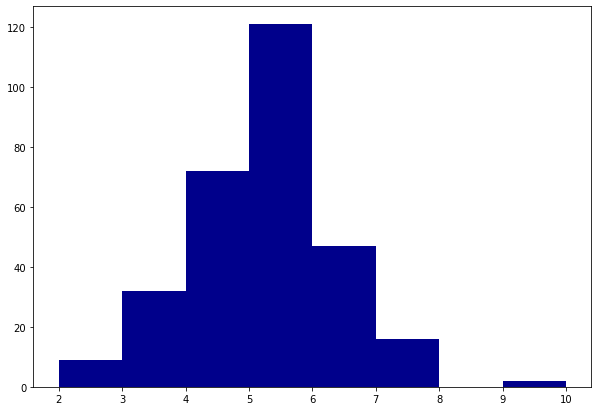

In [16]:
h = np.histogram(d, np.arange(np.min(d),np.max(d)+1))

plt.figure(figsize=(10,7))
plt.bar(h[1][:-1]-.5,h[0], color="darkblue", width=1)
plt.show()

Store in sparse diagonal matices $D$ and $iD$
respectively $D=\text{diag}_i(d_i)$ and $D^{-1} = \text{diag}_i(1/d_i)$.

In [17]:
D = sparse.coo_matrix((d, (np.arange(0,n),np.arange(0,n))))
iD = sparse.coo_matrix((1/d, (np.arange(0,n),np.arange(0,n))))

The normalized weight matrix is defined as
$$ \tilde W_{i,j} = \frac{1}{d_i} W_{i,j}, $$
and hence $\tilde W = D^{-1} W$.

In [18]:
tW = iD.dot(W)

It satisfies
$$ \forall i , \quad \sum_j \tilde W_{i,j} = 1, $$
i.e. $\tilde W \text{I} = \text{I}$ where $\text{I} \in \RR^n$ is the vector
constant equal to one.


The operator $\tilde W \in \RR^{n \times n} $, viewed as an operator
$\tilde W : \RR^n \rightarrow \RR^n$, can be thought as a low pass
filter.


Laplacian and Gradient Operators
--------------------------------
The un-normalized Laplacian is on the contrary a symmetric high pass
operator
$$ L = D-W \in \RR^{n \times n}. $$
It satisfies $L \text{I} = 0$.

In [19]:
L = D - W

The gradient operator compute directional derivative along edges.
It can be used to factor the Laplacian operator, but in practice
it is never computed explicitely since it is never needed in numerical
computation.

To represent the gradient, we index the set of (oriented) edges $ \Ee_0 = (e_k)_{k=1}^{p_0} $
where each edge is $e_k = (i,j) \in \{1,\ldots,n\}^2$ with $i<j$.


The gradient operator is a matrix $G \in \RR^{p_0 \times n}$ defined
as, for all $e_k=(i,j)$ and all $\ell \notin \{i,j\}$,
$$ G_{k,i}=1, \quad G_{k,j}=-1, \quad G_{k,\ell}=0. $$


It is stored as a sparse matrix, and can be thought as a derivative
operator $G : \RR^n \rightarrow \RR^{p_0} $ that maps signal defined
on vertices to differences located along directed edges.

In [20]:
G = sparse.coo_matrix((np.hstack((np.ones(p0),-np.ones(p0))),(np.hstack((np.arange(0,p0),np.arange(0,p0))),np.hstack((E0[0,:],E0[1,:])))))

Display the non-zero entries of $G$ and $W$.

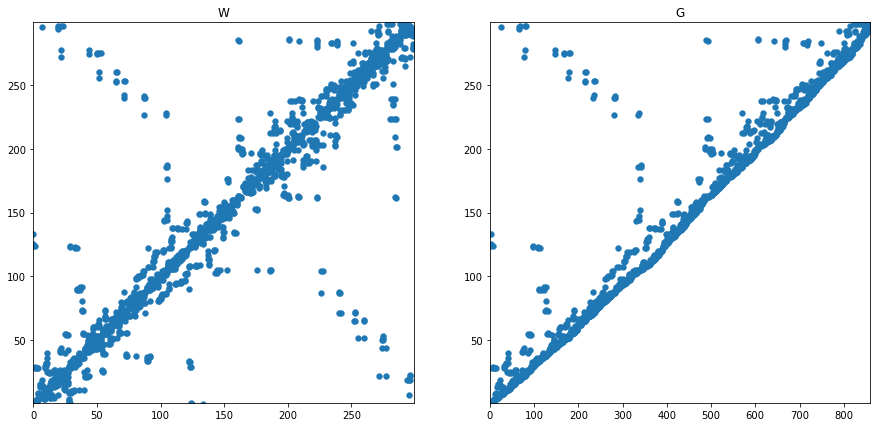

In [21]:
plt.figure(figsize=(15,7))

plt.subplot(1, 2, 1)
plt.scatter(sparse.find(W)[0],sparse.find(W)[1], lw=.3)
plt.xlim(0,np.shape(W)[0])
plt.ylim(1,np.shape(W)[1])
plt.title("W")

plt.subplot(1, 2, 2)
plt.scatter(sparse.find(G)[0],sparse.find(G)[1], lw=.3)
plt.xlim(0,np.shape(G)[0])
plt.ylim(1,np.shape(G)[1])
plt.title("G")

plt.show()

The Laplacian can be factored as follow
$$ L = G^* G $$
where $G^*$ is the transposed matrix (i.e. the adjoint operator, which
can be thought as some kind of divergence).


Check numerically that the factorization indeed hold.

In [22]:
err = sparse.linalg.norm((np.dot(np.transpose(G),G) - L), 'fro')
print("Factorization error (should be 0) = %.2f" %err)

Factorization error (should be 0) = 0.00


Note that this factorization shows that $L$ is a positive semi-definite
operator, i.e. it satisfies

$$ \dotp{L f}{f} = \norm{G f}^2 \geq 0. $$

If the mesh is connected, then only constant signals $f \in \RR^n$ satisfies
$Lf=0$.


Note that this convention is the contrary to the usual convention of
differential calculus, in which a Laplacian is a negative operator.



Function Denoising with Filtering
---------------------------------
A signal defined on the mesh is a vector $f \in \RR^n$, where $f_i \in \RR$
is the value at vertex $1 \leq i \leq n$.


Load a texture image $I$.

In [23]:
M = load_image("elephant.jpg", 256)

Print the image

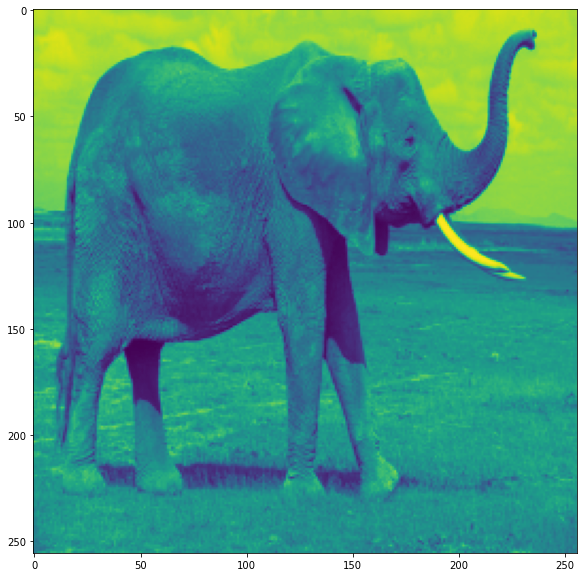

In [24]:
plt.figure(figsize=(10,10))
plt.imshow(M)

Compute spherical coordinates $ (\theta_i,\phi_i)$ for each vertex $x_{0,i}$
on the mesh.

In [25]:
v = X0 - np.tile(np.mean(X0, 1)[:,np.newaxis], (1,n))
theta = np.arccos(v[0,:]/np.sqrt(np.sum(v**2,0)))/np.pi
phi = (np.arctan2(v[1,:],v[2,:])/np.pi + 1)/2.

Interpolate the texture on the mesh.

In [26]:
from scipy import interpolate
from matplotlib import colors

x = np.linspace(0, 1, np.shape(M)[0])
f = rescale(interpolate.RectBivariateSpline(x, x, np.transpose(M)).ev(theta,phi))
my_cmap = (np.repeat(f[:,np.newaxis],3,1))

Display the textured mesh.

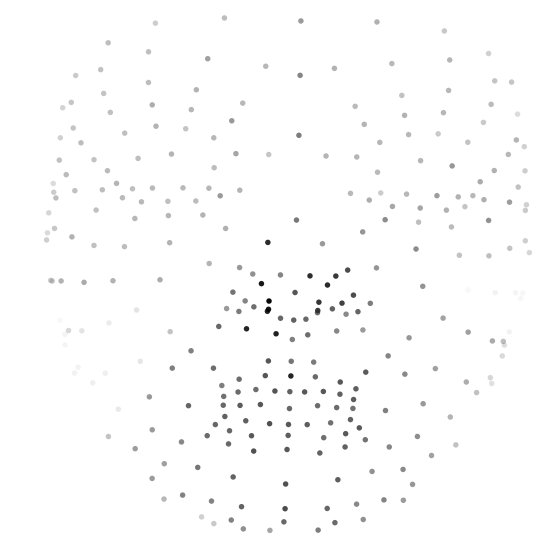

In [27]:
fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X0[0,:], X0[1,:], X0[2,:], lw=0, c=my_cmap, s=30)
ax.axis("off")
ax.view_init(elev=90, azim=-90)
ax.dist = 6

The operator $\tilde W : \RR^n \rightarrow \RR^n$ can be used to smooth
a function $f$, simply by computing $\tilde W f \in \RR^n$.


To further smooth the mesh, it is possible to iterate this process, by
defining $f^{(0)} = f$ and

$$ f^{(\ell+1)} = \tilde W f^{(\ell)}.$$

Note that one has $ f^{(\ell)} = \tilde W^{\ell} f, $
but it is preferable to use the iterative algorithm to do the
computations.

__Exercise 1__

Display the evolution of the image on the mesh as the number of
iterations increases.

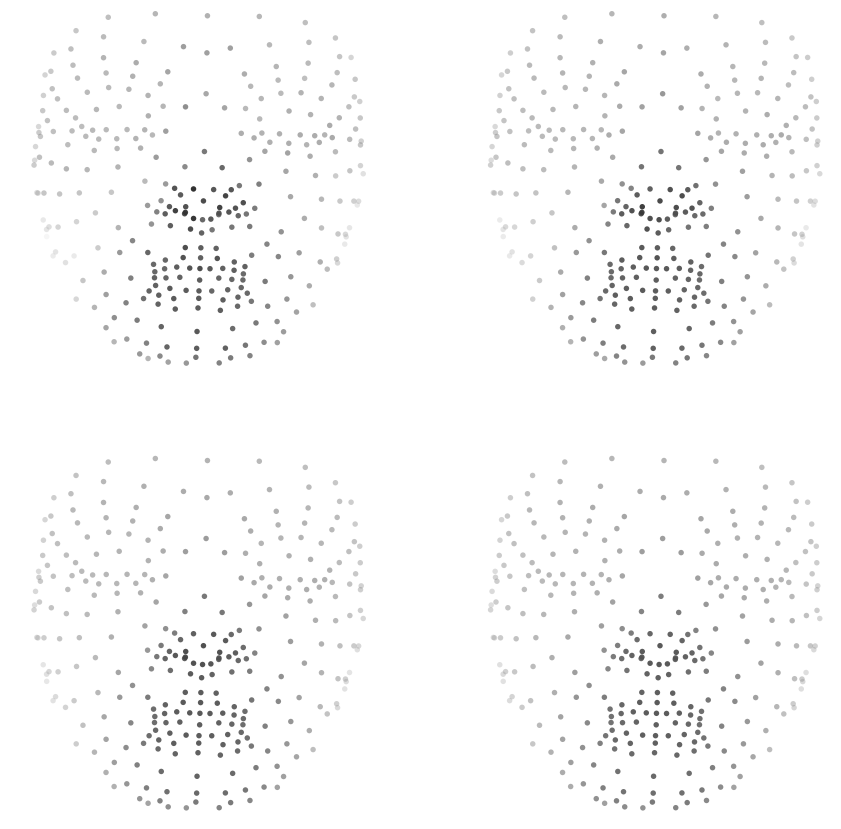

In [28]:
fig = plt.figure(figsize = (15,15))
klist = [1,2,4,8]
i = 0
f1 = np.copy(f)

for k in range(1,max(klist)+1):
    f1 = tW.dot(f1)
    if k == klist[i]:
        ax = fig.add_subplot(2,2,i+1,projection='3d')
        my_cmap = (np.repeat(f1[:,np.newaxis],3,1))
        ax.scatter(X0[0,:], X0[1,:], X0[2,:], lw=0, c=my_cmap, s=30)
        ax.axis("off")
        ax.view_init(elev=90, azim=-90)
        ax.dist = 6
        i = i + 1
plt.show()

Mesh Denoising with Filtering
-----------------------------
The quality of a noisy mesh is improved by applying local averagings,
that removes noise but also tends to smooth features.



The operator $\tilde W : \RR^n \rightarrow \RR^n$ can be used to smooth
a function, but it can also be applied to smooth the position $W \in
\RR^{3 \times n} $. Since they are stored as row of a matrix, one should
applies $\tilde W^*$ (transposed matrix) on the right side.
$$ X^{(0)} = X \qandq X^{(\ell+1)} = X^{(\ell)} W^* $$

In [103]:
niter = 1
X1 = np.copy(X)
for i in range(niter):
    X1 = tW.dot(np.transpose(X1)).transpose()

We can compute the errors in dB with respect to the clean mesh, using

$$ \text{SNR}(X,Y) = -20 \log_{10} \pa{ \norm{X-Y}/\norm{Y} }. $$

In [107]:
pnoisy = snr(X0, X)
pfilt  = snr(X0, X1)
poriginal = snr(X, X)
print("Noisy = %f dB, Denoised = %f dB, Original = %.f dB" %(pnoisy,pfilt, poriginal))

Noisy = 41.764426 dB, Denoised = 26.027193 dB, Original = inf dB


Display the results.

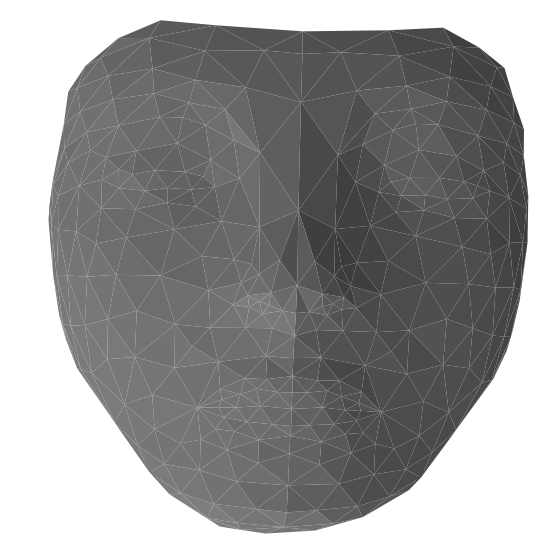

In [105]:
plt.figure(figsize=(10,10))
plot_mesh(X1, F)

__Exercise 2__

Determine the optimal number of iterations to maximize the SNR.
Record, for each number $i$ of iteration, the SNR in $err(i)$.

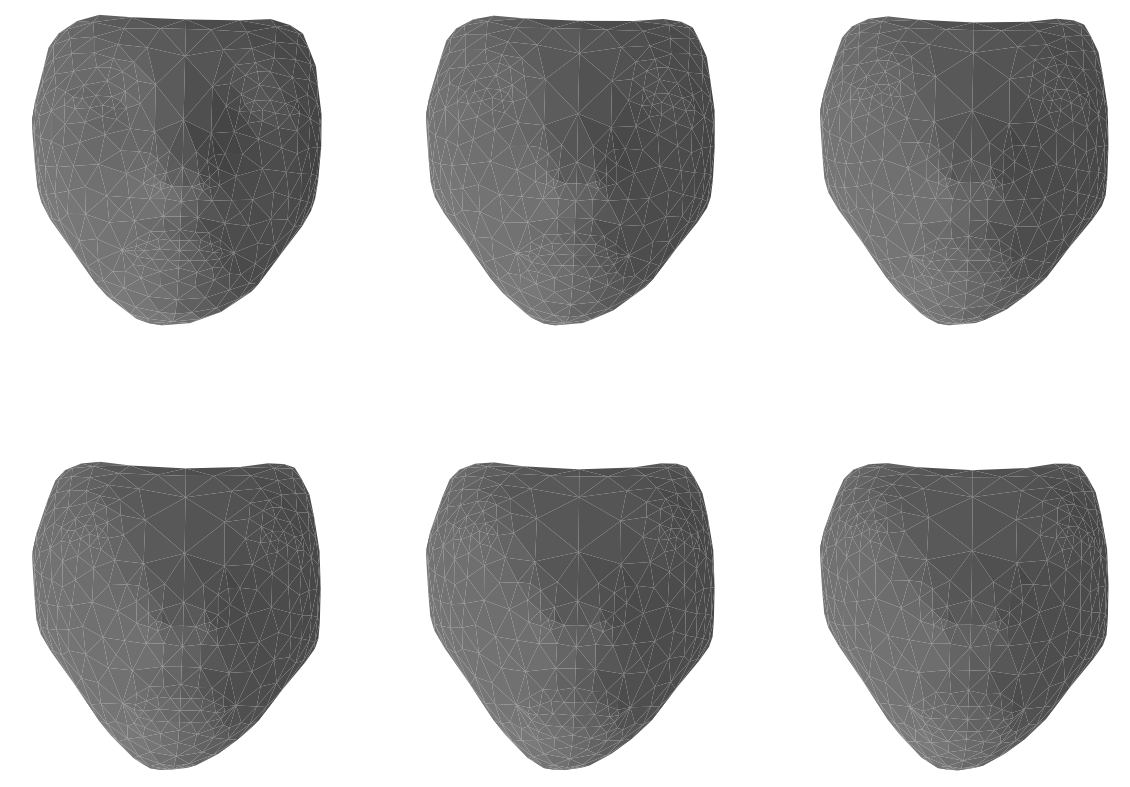

In [32]:
plt.figure(figsize=(20,15))
X1 = X
erre = [pnoisy]
temps = []
starttime = tps.time()
t=0

for i in range(1,20):
    starttime = tps.time() - t
    X1 = tW.dot(np.transpose(X1)).transpose()
    erre = erre + [snr(X0, X1)]
    t =(tps.time() - starttime)
    temps += [t]
    
    if i%3 == 0:
        plot_mesh(X1, F, subplot=[2,3,i//3])
        
    if erre[-1] > max(erre[:-1]):
        Xbest = X1

In [33]:
a = np.amax(erre)
print("dB max = ", a)
b = np.argmax(erre)
print("argmax = ", b)

dB max =  41.764426175902294
argmax =  0


Plot time took as function of the number of iteration

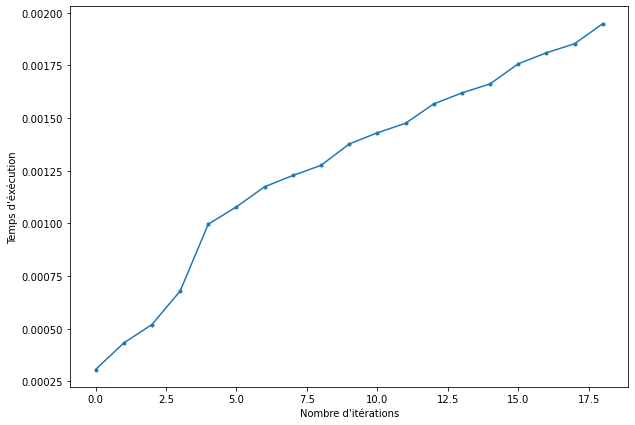

In [34]:
plt.figure(figsize=(10,7))
plt.plot(temps, '.-')
plt.xlabel("Nombre d'itérations")
plt.ylabel("Temps d'éxécution")
plt.show()

Plot the error as a function of the number of iterations.

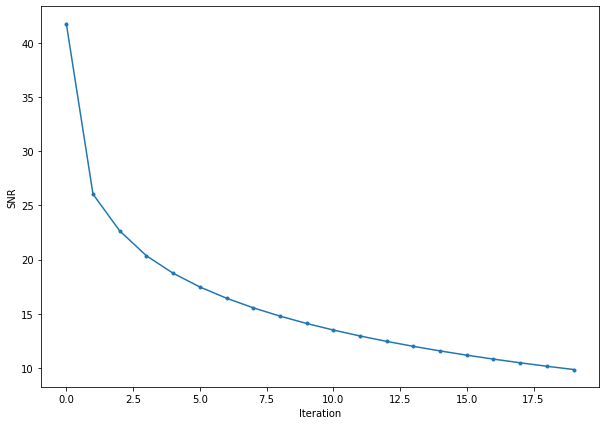

In [35]:
plt.figure(figsize=(10,7))
plt.plot(erre, '.-')
plt.xlabel("Iteration")
plt.ylabel("SNR")
plt.show()

### Time of the best denoising

In [36]:
def filtering(niter) :
    X1 = X
    erre = [pnoisy]

    for i in range(1,niter +1):
        X1 = tW.dot(np.transpose(X1)).transpose()
        erre = erre + [snr(X0, X1)]
        
        if erre[-1] > max(erre[:-1]):
            Xbest = X1

In [37]:
%timeit filtering(b)

1.12 µs ± 192 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)


Mesh Denoising with Linear Heat Diffusion
-----------------------------------------
Iterative filtering is closely related to the heat diffusion. The heat
diffusion is a linear partial differential equation (PDE) that compute a continuous denoising result for
arbitrary time $t$. It is thus more precise than simple iterative
filterings.


This PDE defines a function $f_t \in \RR^n$ parameterized by the time
$t>0$ as
$$ \forall t>0, \quad \pd{f_t}{t} = -\tilde L f_t
      \qandq f_0 = f, $$
where $ \tilde L $ is the symetric normaled Laplacian defined as
$$ \tilde L = D^{-1} L = \text{Id}_n - \tilde W. $$

In [38]:
tL = iD.dot(L)

This PDE is applied to the three components of a 3-D mesh to define a
surface evolution
$$ \forall t>0, \quad \pd{X_t}{t} = -X_t \tilde L^*
      \qandq f_0 = f. $$


One can approximate the solution to this PDE using explicit finite
difference in time (Euler explicit scheme)
$$ X^{(\ell+1)} = X^{(\ell)} -  \tau X^{(\ell)} \tilde L^*
      = (1-\tau) X^{(\ell)} + \tau  X^{(\ell)} \tilde W^* $$
where $0 < \tau < 1$ is a (small enough) time step and $f^{(\ell)}$ is
intended to be an approximation of $X_t$ at time $t=\tau \ell$.
The smaller $\tau$, the better the approximation.


One can see that with $\tau=1$, one recovers the iterative filtering
method.


Time step $\tau$.

In [92]:
tau = 0.2

Maximum time of resolution.

In [93]:
Tmax = 10

Number of iterations needed to reach this time.

In [94]:
niter = int(np.ceil(Tmax/tau))

Initial solution at time $t=0$.

In [95]:
Xt = np.copy(X)

We use an explicit discretization in time of the PDE. Here is one
iteration.

In [96]:
Xt = Xt - tau*(tL.dot(np.transpose(Xt))).transpose()

__Exercise 3__

Compute the linear heat diffusion.
Monitor the denoising
SNR $err(l)$ between $X_t$ and $X_0$ at iteration index $l$.

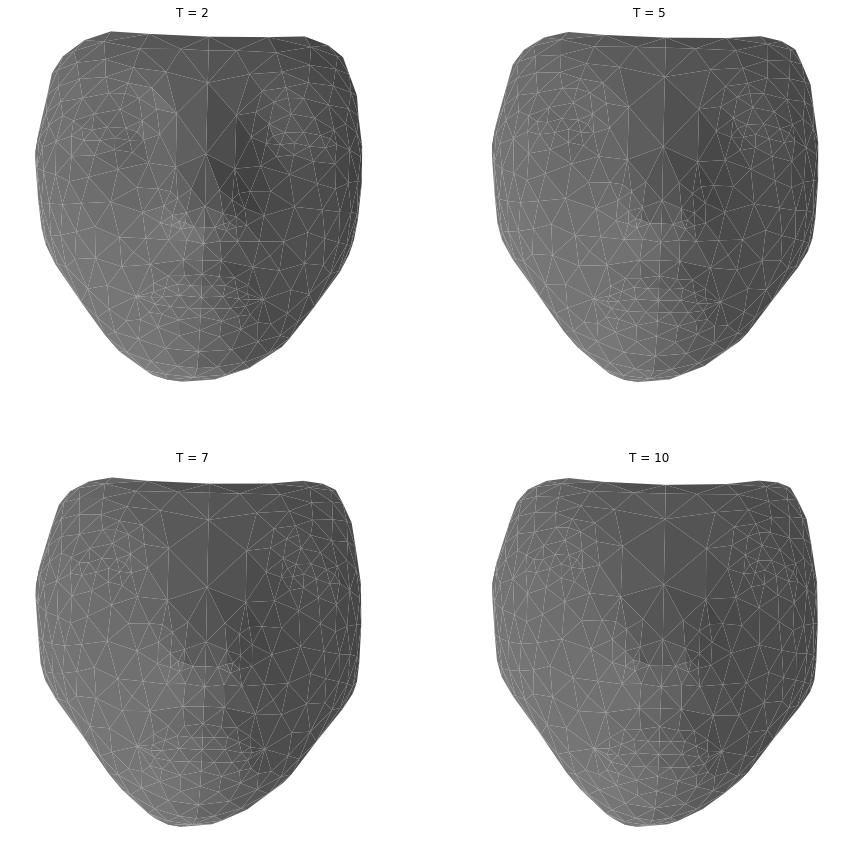

In [98]:
plt.figure(figsize=(15,15))
Xt = np.copy(X)
k = 0
sob = []
err = []

for i in range(1,niter+1):
    # step
    Xt = Xt - tau*(tL.dot(np.transpose(Xt))).transpose()
    # error
    err = err + [snr(X0, Xt)]
    if i % np.floor(niter/4) == 0:
        k = k + 1
        plot_mesh(Xt, F, subplot=[2,2,k], title="T = %i" %(Tmax*k/4))

Plot the error as a function of time.

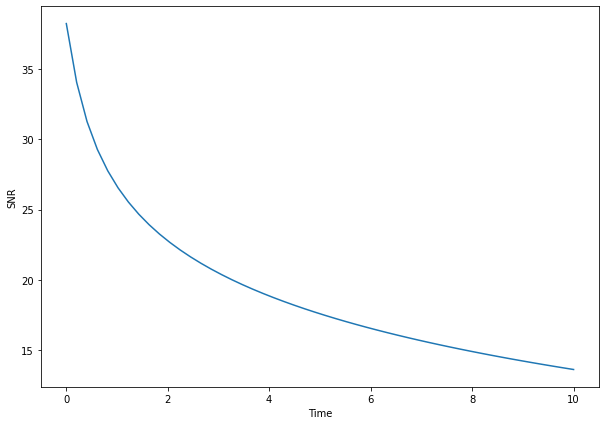

In [99]:
t = np.linspace(0, Tmax, niter)

plt.figure(figsize=(10,7))
plt.plot(t, err)
plt.xlabel("Time")
plt.ylabel("SNR")
plt.show()

### Comparaisons of the different $\tau$

In [46]:
Tau = np.logspace(-2.5, 0.3, 20)
print(Tau)

[0.00316228 0.00443985 0.00623357 0.00875196 0.01228779 0.01725211
 0.02422203 0.03400783 0.04774714 0.06703719 0.0941205  0.13214558
 0.18553295 0.26048905 0.36572773 0.51348329 0.72093272 1.0121926
 1.42112271 1.99526231]


Maximum time of resolution.

In [47]:
Tmax = 40

Initial solution at time $t=0$.

In [48]:
Xt = np.copy(X)



Compute the linear heat diffusion.
Monitor the denoising
SNR $err(l)$ between $X_t$ and $X_0$ at iteration index $l$.

tau =  0.0031622776601683794
dB max =  41.812979690445346
argmax =  3


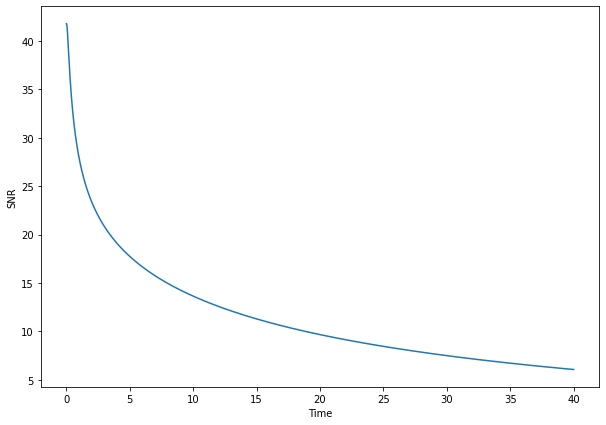

tau =  0.004439851260478999
dB max =  41.81327062540224
argmax =  2


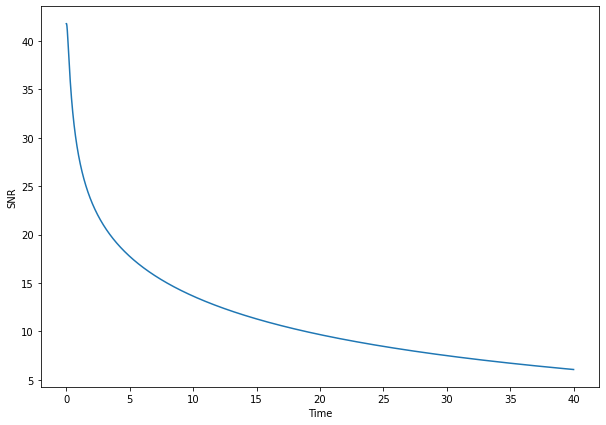

tau =  0.006233570019315558
dB max =  41.81301143614509
argmax =  1


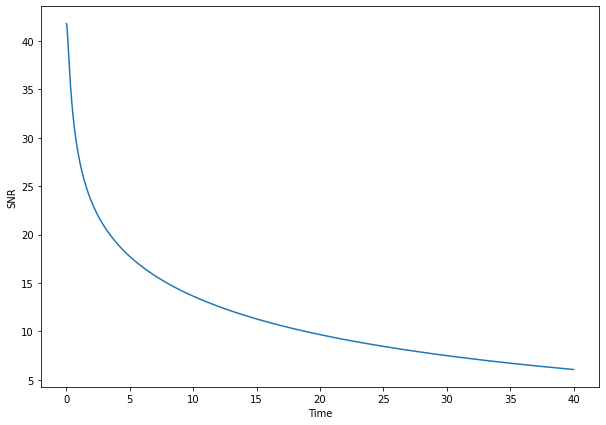

tau =  0.008751958772041742
dB max =  41.813486538106375
argmax =  0


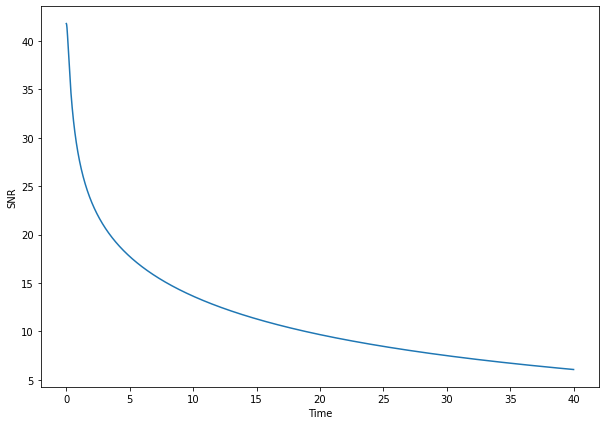

tau =  0.012287787272810432
dB max =  41.804597164219864
argmax =  0


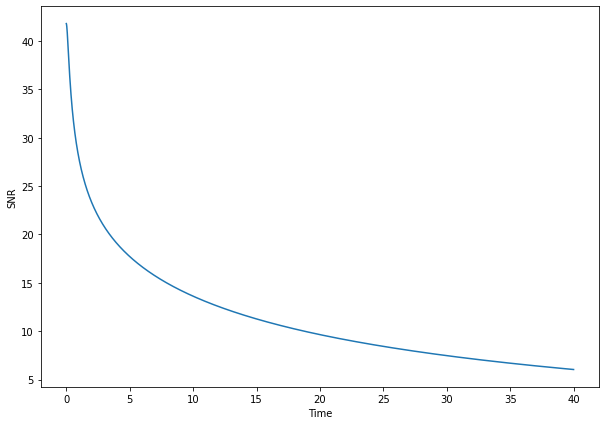

tau =  0.017252105499420408
dB max =  41.76465728548797
argmax =  0


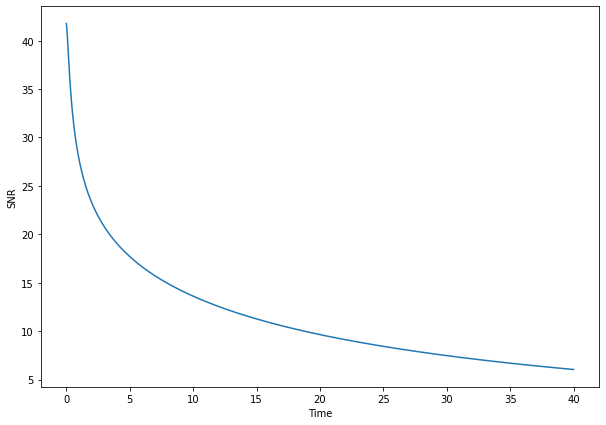

tau =  0.024222029365833692
dB max =  41.6566770433323
argmax =  0


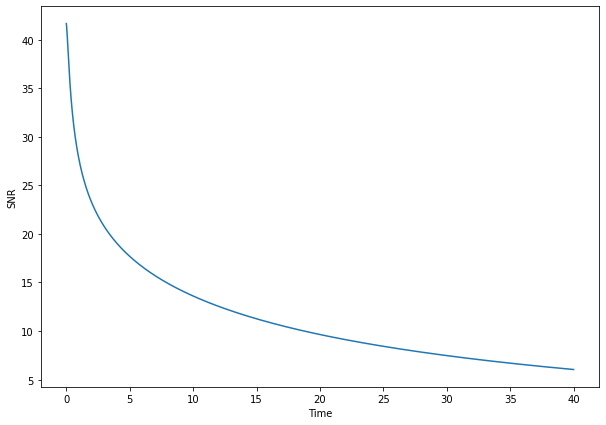

tau =  0.03400783206542649
dB max =  41.412390644340604
argmax =  0


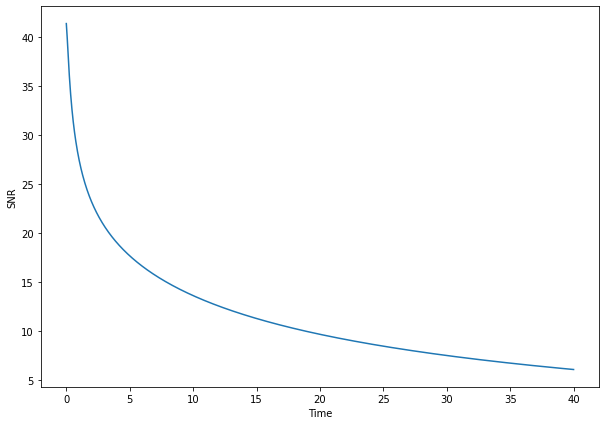

tau =  0.047747140601752946
dB max =  40.92191234072666
argmax =  0


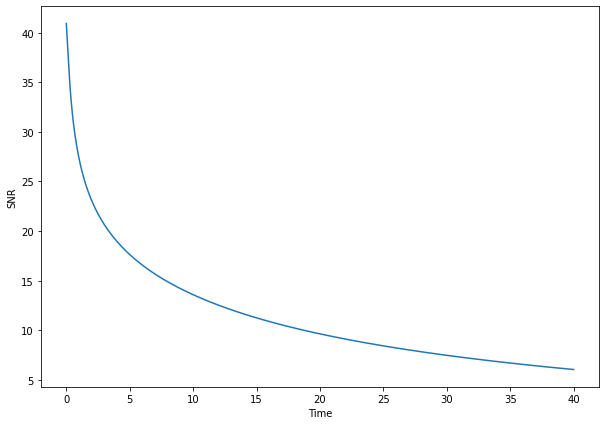

tau =  0.06703718811765351
dB max =  40.046679825274666
argmax =  0


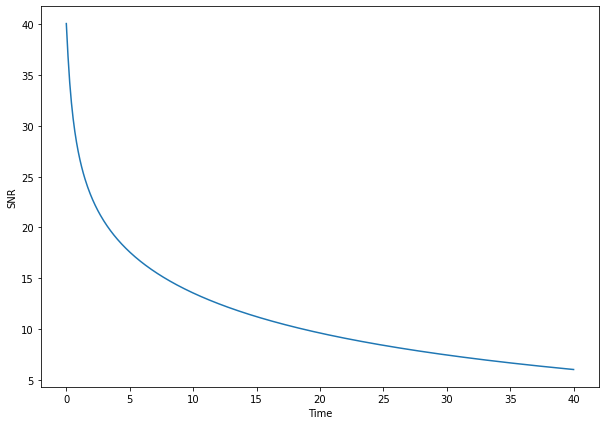

tau =  0.09412049672680665
dB max =  38.67927500512958
argmax =  0


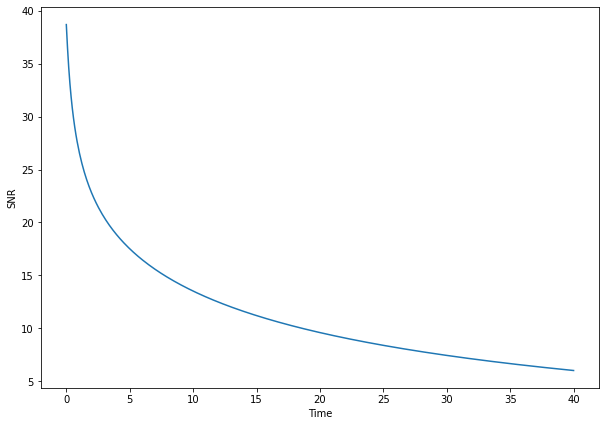

tau =  0.13214557699755294
dB max =  36.8200167536429
argmax =  0


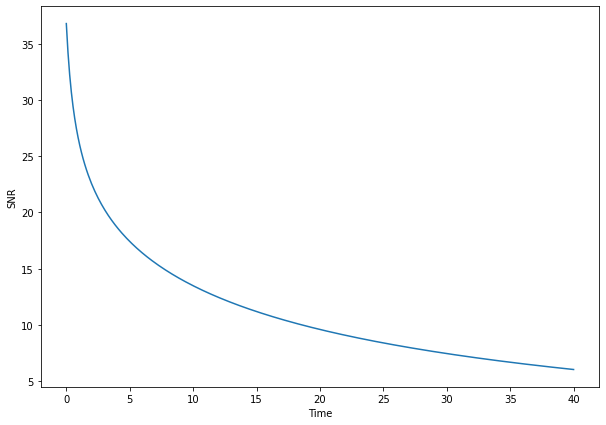

tau =  0.1855329511349961
dB max =  34.58437091636954
argmax =  0


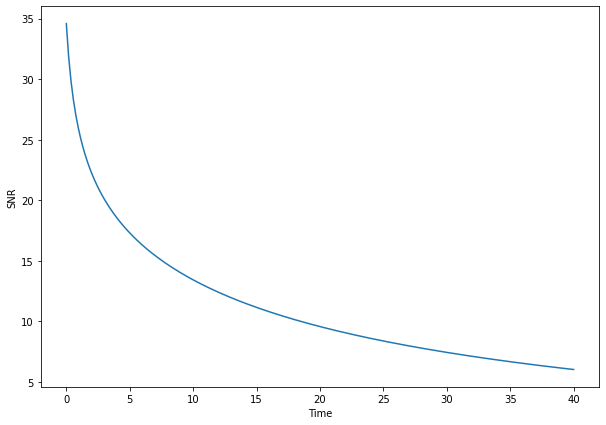

tau =  0.2604890510826428
dB max =  32.13285259692431
argmax =  0


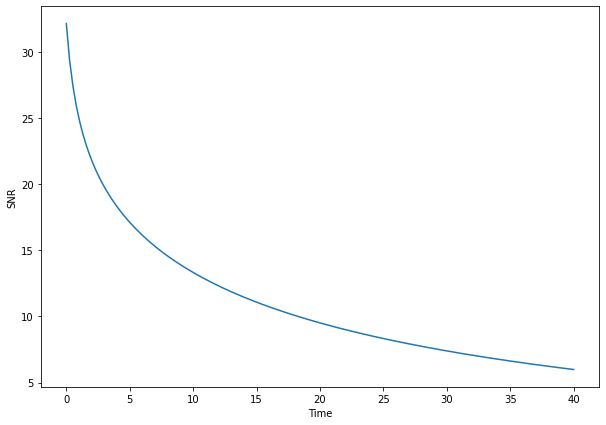

tau =  0.36572773363888267
dB max =  29.60804317899003
argmax =  0


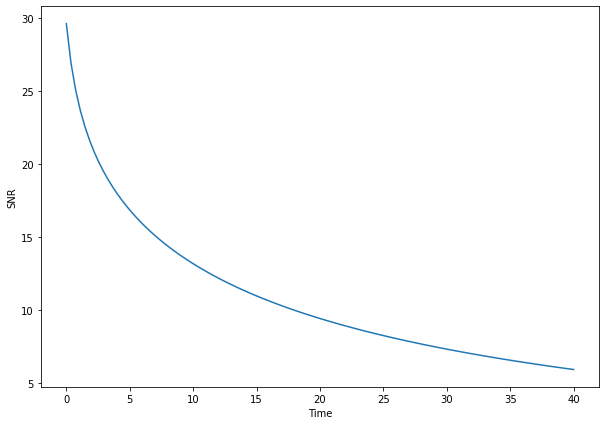

tau =  0.5134832907437549
dB max =  27.1190881969042
argmax =  0


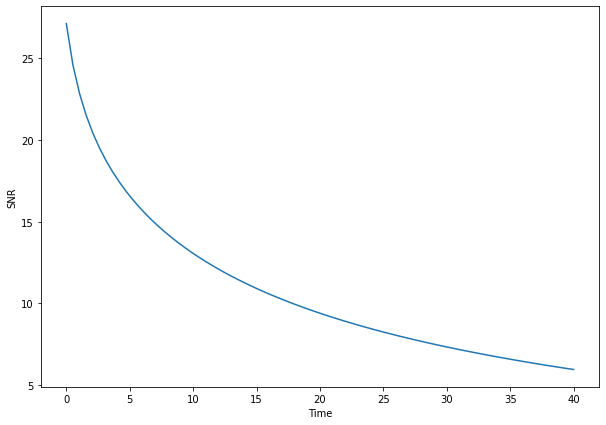

tau =  0.7209327202223522
dB max =  24.751235097312943
argmax =  0


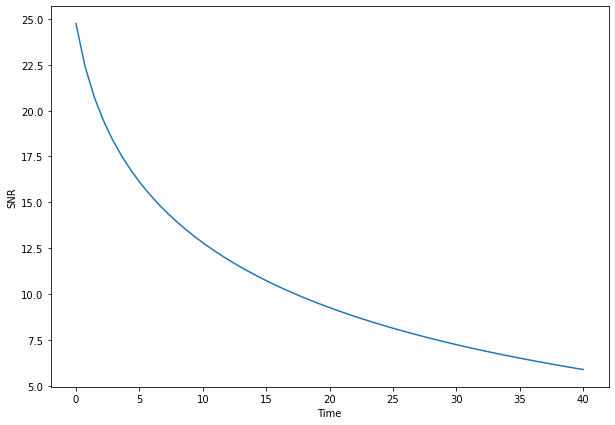

tau =  1.0121925999468788
dB max =  22.567241944061255
argmax =  0


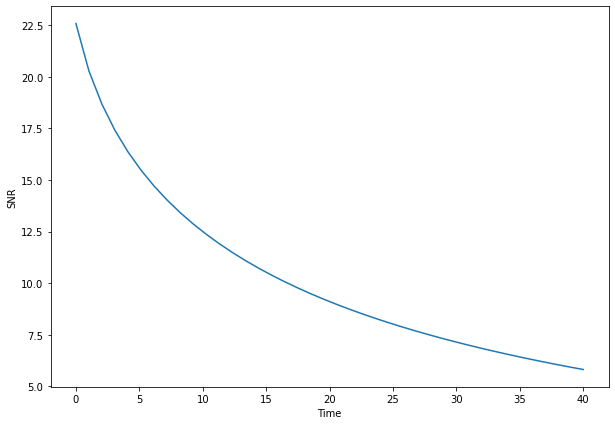

tau =  1.421122707638006
dB max =  20.546368680564655
argmax =  0


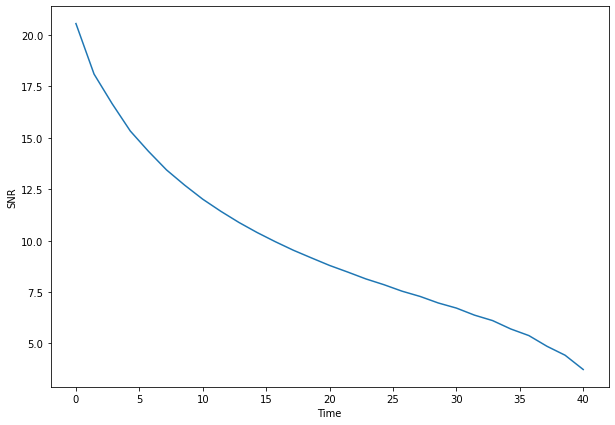

tau =  1.9952623149688795
dB max =  18.301831694896887
argmax =  0


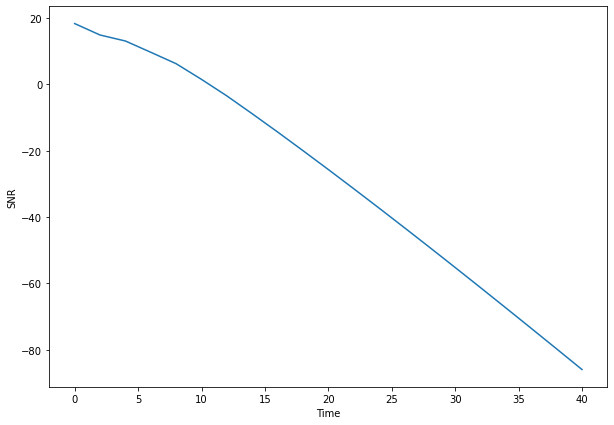

In [49]:
dbMax = []
argMax = []
for tau in Tau :
    niter = int(np.ceil(Tmax/tau))
    Xt = np.copy(X)
    Xt = Xt - tau*(tL.dot(np.transpose(Xt))).transpose()
    k = 0
    sob = []
    err = []
    print("tau = ", tau)
    for i in range(1,niter+1):
    # step
        Xt = Xt - tau*(tL.dot(np.transpose(Xt))).transpose()
    # error
        err = err + [snr(X0, Xt)]
        if i % np.floor(niter/4) == 0:
            k = k + 1
            #plot_mesh(Xt, F, subplot=[2,2,k], title="T = %i" %(Tmax*k/4)) 
    t = np.linspace(0, Tmax, niter)
    a = np.amax(err)
    dbMax += [a]
    print("dB max = ", a)
    b = np.argmax(err)
    argMax += [b]
    print("argmax = ", b)
    plt.figure(figsize=(10,7))
    plt.plot(t, err)
    plt.xlabel("Time")
    plt.ylabel("SNR")
    plt.show()

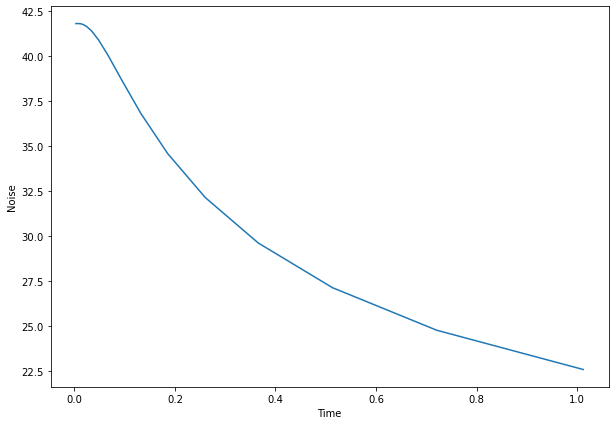

In [50]:
 plt.figure(figsize=(10,7))
plt.plot(Tau[:-2], dbMax[:-2])
plt.xlabel("Time")
plt.ylabel("Noise")
plt.show()

Let compare the different time to reach the maximum

In [51]:
def heat_reg(tau, niter) :
    Xt = np.copy(X)
    Xt = Xt - tau*(tL.dot(np.transpose(Xt))).transpose()
    k = 0
    sob = []
    err = []
    for i in range(1,niter+1):
    # step
        Xt = Xt - tau*(tL.dot(np.transpose(Xt))).transpose()
    # error
        err = err + [snr(X0, Xt)]
        if i % np.floor(niter/4) == 0:
            k = k + 1
    return tau

In [52]:
for i in range(len(Tau)) :
    %timeit heat_reg(tau, argMax[i])

655 µs ± 80.6 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
498 µs ± 53.5 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
305 µs ± 37.1 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
106 µs ± 13.4 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
104 µs ± 5.63 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
98.7 µs ± 10.2 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
97.3 µs ± 6.92 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
96.2 µs ± 5.89 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
99.3 µs ± 6.91 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
92.9 µs ± 6.05 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
99.5 µs ± 8.27 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
98.2 µs ± 6.08 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
99.9 µs ± 9.72 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
102 µs ± 6.04 µs per loop (mean ±

In [53]:
temps = []
start_time = 0.0
for i in range(len(Tau)) :
    starttime = tps.time()
    print(heat_reg(Tau[i], argMax[i]))
    t =(tps.time() - starttime)
    temps += [t]
    print(t)

0.0031622776601683794
0.010850191116333008
0.004439851260478999
0.0014388561248779297
0.006233570019315558
0.0007865428924560547
0.008751958772041742
0.00047397613525390625
0.012287787272810432
0.0004718303680419922
0.017252105499420408
0.0007443428039550781
0.024222029365833692
0.0008015632629394531
0.03400783206542649
0.0005588531494140625
0.047747140601752946
0.00045418739318847656
0.06703718811765351
0.0004851818084716797
0.09412049672680665
0.0005409717559814453
0.13214557699755294
0.0005605220794677734
0.1855329511349961
0.0005552768707275391
0.2604890510826428
0.0004684925079345703
0.36572773363888267
0.0004680156707763672
0.5134832907437549
0.00048661231994628906
0.7209327202223522
0.0004546642303466797
1.0121925999468788
0.0009860992431640625
1.421122707638006
0.0005528926849365234
1.9952623149688795
0.00046753883361816406


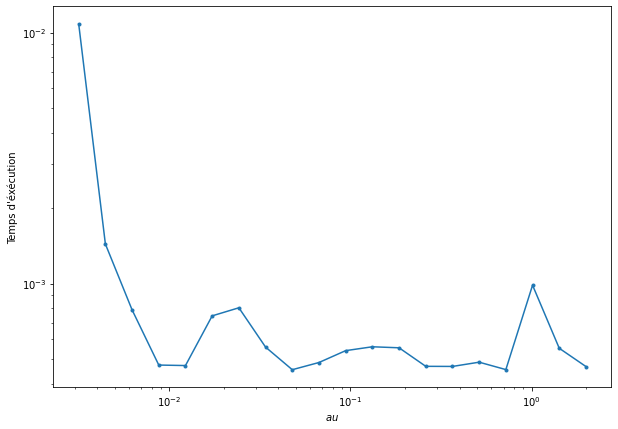

In [54]:
plt.figure(figsize=(10,7))
plt.plot(Tau, temps, '.-')
plt.yscale('log')
plt.xscale('log')
plt.xlabel("$\tau$")
plt.ylabel("Temps d'éxécution")
plt.show()

Mesh Denoising with Sobolev Regularization
------------------------------------------
Instead of solving an evolution PDE, it is possible to do denoising by
solving a quadratic regularization.


Denoting $G \in \RR^{p_0 \times n}$ the gradient operator, the Soboleb
norm of a signal $f \in \RR^n$ is defined as
$$ J(f) = \norm{G f}^2 = \dotp{L f}{f}. $$
It is extended to mesh poisition $X \in \RR^{3 \times n}$ as
$$ J(X) = \norm{X G^*}^2 = \dotp{X L}{X}, $$
(remeber that $L$ is symmetric).



Denoising of a noisy set of vertices $X$ is then defined as the solution of a quadratic minimization
$$ X_\mu = \uargmin{Z \in \RR^{3 \times n}} \norm{Z-X}^2  + \mu J(Z)^2. $$
Here $\mu \geq 0$ controls the amount of denoising, and should be
proportional to the noise level.


The solution to this problem is obtained by solving the following
symmetric linear system
$$ X_\mu^* = (\text{Id}_n + \mu L )^{-1} X^* $$
(remember that the mesh vertex position are stored as rows, hence the transposed).


We select a penalization weight $\mu$. The larger, the smoother the result will
be (more denoising).

Let Solve this problem for various $\mu$ on a 3D mesh and draw the evolution of the SNR denoising error as a function of $\mu$.

dB max =  21.771057651513217
argmax =  0


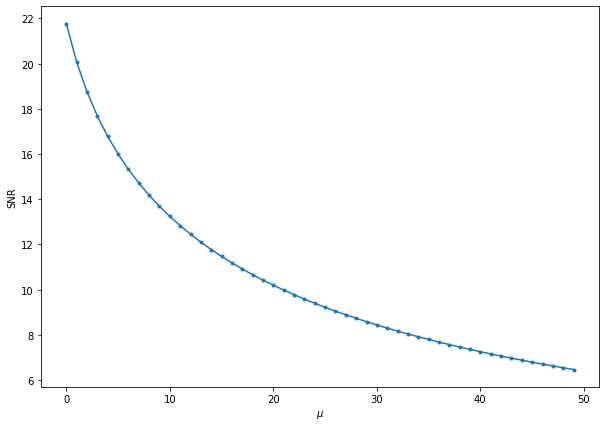

In [57]:
Xmu = np.copy(X)
ntests = 50
muList = np.linspace(3, ntests, ntests)/5.
errR = []
temps = []

for i in range(ntests):
    mu = muList[i]
    starttime = tps.time()
    t =(tps.time() - starttime)
    temps += [t]
    A = sparse.identity(n) + mu*L
    
    for k in range(3):
        Xmu[k,:] = sparse.linalg.cg(A, X[k,:])[0].transpose()
        
    errR = errR + [snr(X0, Xmu)]
a = np.amax(errR)
print("dB max = ", a)
b = np.argmax(errR)  
print("argmax = ", b)
plt.figure(figsize=(10,7))
plt.plot(errR, '.-')
plt.xlabel("$\mu$")
plt.ylabel("SNR")
plt.show()

Print evolution time depending on $\mu$

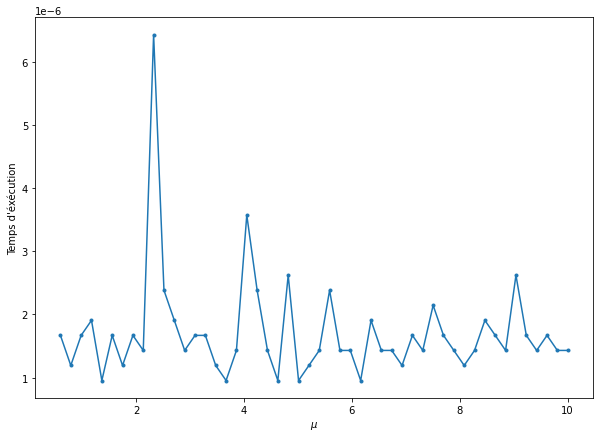

In [58]:
plt.figure(figsize=(10,7))
plt.plot(muList, temps, '.-')
plt.xlabel("$\mu$")
plt.ylabel("Temps d'éxécution")
plt.show()

In [59]:
mu = b

We set up the matrix of the system.
It is important to use sparse matrix to have fast resolution scheme.

In [60]:
A = sparse.identity(n) + mu*L

We solve the system for each coordinate of the mesh.
Since the matrix is highly sparse, it is very interesting
to use an iterative method to solve the system, so here
we use a conjugate gradient descent (function cg from sparse.linalg).

In [61]:
Xmu = np.copy(X)
for i in range(3):
    b = X[i,:]
    Xmu[i,:] = sparse.linalg.cg(A, b)[0].transpose()

Display the best result.

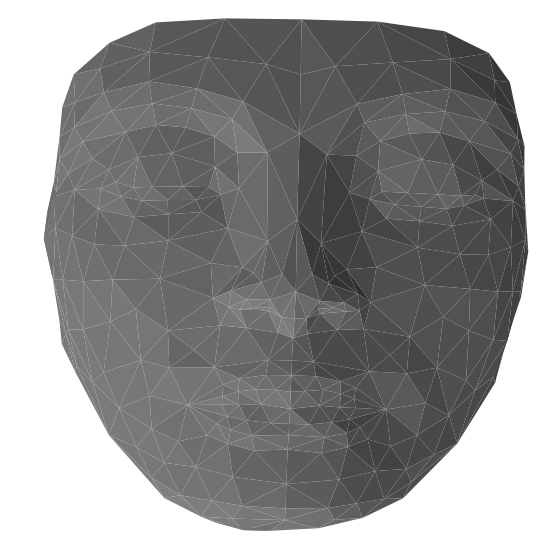

In [62]:
plt.figure(figsize=(10,10))
plot_mesh(Xmu, F)

### Time of the best denoising

In [63]:
def sobolev(ntest) :
    muList = np.linspace(3, 15, ntests)/5.
    errR = []

for i in range(ntests):
    mu = muList[i]
    A = sparse.identity(n) + mu*L
    
    for k in range(3):
        Xmu[k,:] = sparse.linalg.cg(A, X[k,:])[0].transpose()
        
    errR = errR + [snr(X0, Xmu)]

In [64]:
%timeit sobolev(b)

83.3 µs ± 17.8 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
